In [1]:

import pyodbc
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np

klients = []
with open("patientenliste.txt", "r") as patienten:
	lines = patienten.readlines()

klients = [int(x.replace("\n","")) for x in lines]

In [2]:
klients01 = tuple([str(x)[:-2] for x in klients if x%10==1])
klients02 = tuple([str(x)[:-2] for x in klients if x%10==2])
klients03 = tuple([str(x)[:-2] for x in klients if x%10==3])

In [3]:
connection = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="FH_Master_2122",
    database="forschung"
)

cursor = connection.cursor()

sql_query = "SELECT * FROM medikamentgaben WHERE KlientId IN"+str(klients01)
cursor.execute(sql_query)
myresult = cursor.fetchall()
drugs01 = pd.DataFrame(myresult, columns = ['id', 'klientid','datum','zeitpunkt',
                                          'bezeichnung','pzn','menge','einheit','atccode'])


drugs01["klientid2"] = drugs01["klientid"]*100 +1
drugs01 = drugs01[drugs01.klientid2.isin(klients)]

cursor.execute("SELECT * FROM medikamentinhaltsstoffe")
myresult = cursor.fetchall()
inhalt01 = pd.DataFrame(myresult, columns = ['id', 'pzn','bezeichnung','menge','einheit'])

cursor.close()
connection.disconnect()

In [4]:
connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                            'SERVER=pc-caro;DATABASE=Forschung02;'
                            'Trusted_Connection=yes;')
cursor=connection.cursor()

sql_query = "SELECT * FROM medikamentgaben WHERE KlientId IN"+str(klients02)

drugs02 = pd.read_sql_query(sql_query, connection)
drugs02.columns = ['id', 'klientid','datum','zeitpunkt',
                'bezeichnung','pzn','menge','einheit','atccode']


drugs02["klientid2"] = drugs02["klientid"]*100 +2
drugs02 = drugs02[drugs02.klientid2.isin(klients)]

inhalt02 = pd.read_sql_query('SELECT * FROM medikamentinhaltsstoffe', connection)
inhalt02.columns = ['id', 'pzn','bezeichnung','menge','einheit']

cursor.close()
connection.close()

In [5]:
connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                            'SERVER=pc-caro;DATABASE=Forschung03;'
                            'Trusted_Connection=yes;')
cursor=connection.cursor()
sql_query = "SELECT * FROM medikamentgaben WHERE KlientId IN"+str(klients03)

drugs03 = pd.read_sql_query(sql_query, connection)
drugs03.columns = ['id', 'klientid','datum','zeitpunkt',
                'bezeichnung','pzn','menge','einheit','atccode']


drugs03["klientid2"] = drugs03["klientid"]*100 +3
drugs03 = drugs03[drugs03.klientid2.isin(klients)]

inhalt03 = pd.read_sql_query('SELECT * FROM medikamentinhaltsstoffe', connection)
inhalt03.columns = ['id', 'pzn','bezeichnung','menge','einheit']

cursor.close()
connection.close()

In [6]:
drugs = pd.concat([drugs01, drugs02, drugs03], ignore_index=True)
inhalt = pd.concat([inhalt01, inhalt02, inhalt03], ignore_index=True)
myinhalt = inhalt[["pzn","bezeichnung","menge","einheit"]]
di = pd.merge(drugs, myinhalt, on='pzn', how='inner')
di.columns = ["id","klientid","datum","zeitpunkt","medikamentbezeichnung",
              "pzn","anzahl_eingenommen","einheit_eingenommen","atccode","klientid2",
              "inhaltsstoff","menge_pro_medikament","einheit"]

top50=di.inhaltsstoff.value_counts()[:47].index

klasse = "Diabetes Blutdruck Schmerz Blutdruck Diabetes Diabetes Blutverdünnung Diabetes Diabetes Magenschutz Blutdruck Cholesterinsenker Schilddrüsenhormon Blutdruck Diabetes Blutdruck Blutverdünnung Mineralstoff Schmerz Parkinson Diabetes Säure-Basen-Puffer Diabetes Blutdruck Mineralstoff Beruhigung Abführmittel Schmerz Blutdruck Gicht Vitamin Diabetes Schmerz Schmerz Beruhigung Abführmittel Parkinson Diabetes Blutdruck Vitamin Asthma Depression Depression Beruhigung Blutdruck Blutdruck Augendruck"
klasse = klasse.split()
mydict = dict(zip(list(top50.values), klasse))
mydict["Acetylcystein"] = "Hustenlöser"
mydict["Amoxicillin-3-Wasser"] = "Antibiotikum"
mydict["Cefuroxim axetil"] = "Antibiotikum"
mydict["Ciprofloxacin hydrochlorid-1-Wasser"] = "Antibiotikum"
mydict["Clavulansäure kalium"] = "Antibiotikum"
mydict["Clotrimazol"] = "Pilz"
mydict["Co-trimoxazol"] = "Antibiotikum"
mydict["Colecalciferol, ölige Lösungen"] = "Vitamin"
mydict["Eisen(II)-glycin-sulfat-Komplex"] = "Mineralstoff"
mydict["Enoxaparin natrium"] = "Blutverdünnung"
mydict["Flupredniden 21-acetat"] = "Hautentzündung"
mydict["Folsäure"] = "Folsäure"
mydict["Gentamicin sulfat"] = "Antibiotikum"
mydict["Hydrochlorothiazid"] = "Blutdruck"
mydict["Ibuprofen"] = "Schmerz"
mydict["Metoclopramid hydrochlorid-1-Wasser"] = "Übelkeit"
mydict["Miconazol nitrat"] = "Pilz"
mydict["Nystatin"] = "Pilz"
mydict["Paracetamol"] = "Schmerz"
mydict["Pipamperon dihydrochlorid"] = "Beruhigung"
mydict["Prednisolon"] = "Kortison"
mydict["Xipamid"] = "Blutdruck"
mydict["Zinkoxid"] = "Wundheilung"
mydict["Zopiclon"] = "Beruhigung"

di["verwendung"] = di["inhaltsstoff"].map(mydict)



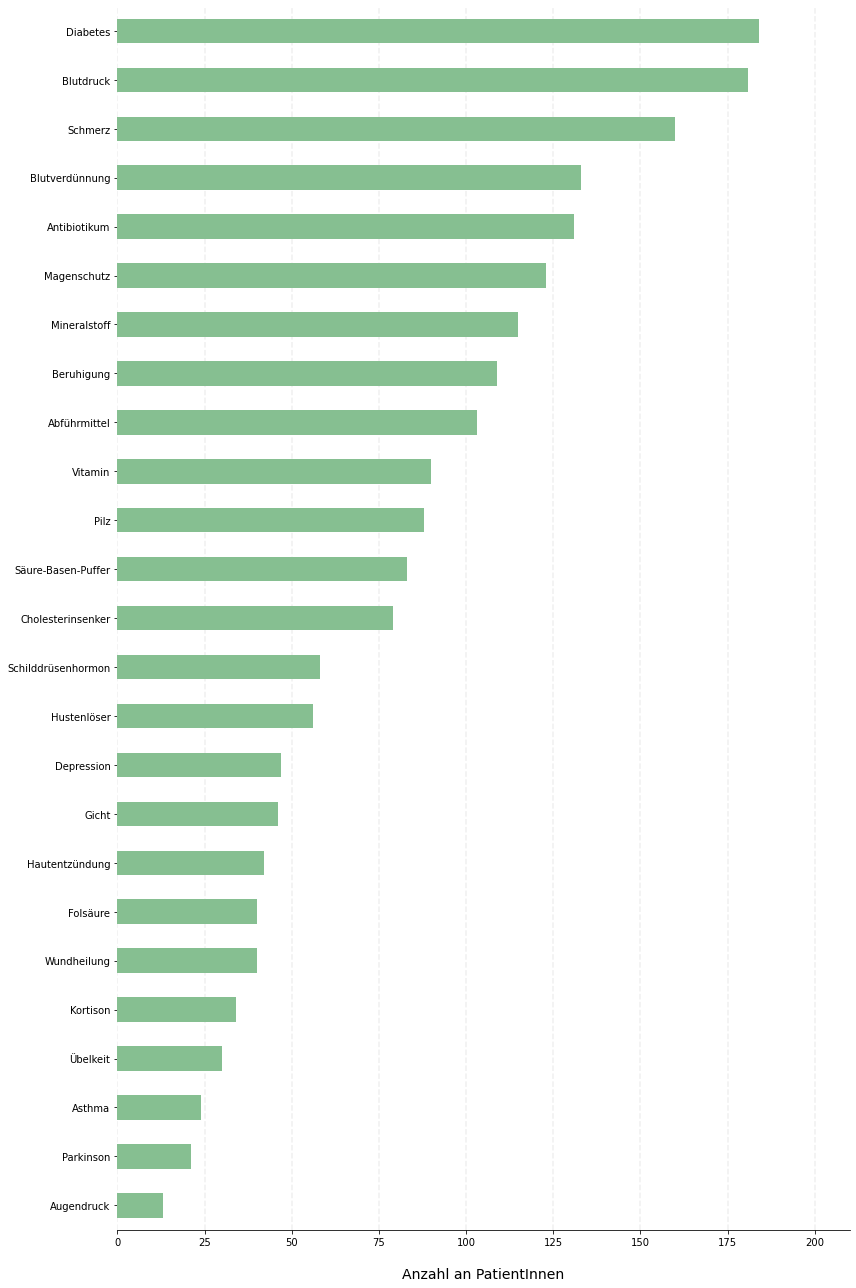

In [7]:
#len(di.inhaltsstoff.unique())
#di.groupby("inhaltsstoff")["klientid2"].value_counts()
df = di.groupby(["klientid2","verwendung"]).size().unstack(fill_value=0)
df2 = df.iloc[:][:] > 0
myseries = df2.sum(axis=0)

fig, ax = plt.subplots()
ax = myseries.sort_values().plot(kind='barh',figsize=(12,18),
                            color='#86bf91', zorder=2)
ax.set_ylabel("")
ax.set_xlabel("Anzahl an PatientInnen",labelpad=20, size=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.9, color='#eeeeee', zorder=1)
fig.tight_layout()
fig.savefig("patien_per_medi_art.pdf")

In [8]:
myseries.sort_values()

verwendung
Augendruck             13
Parkinson              21
Asthma                 24
Übelkeit               30
Kortison               34
Wundheilung            40
Folsäure               40
Hautentzündung         42
Gicht                  46
Depression             47
Hustenlöser            56
Schilddrüsenhormon     58
Cholesterinsenker      79
Säure-Basen-Puffer     83
Pilz                   88
Vitamin                90
Abführmittel          103
Beruhigung            109
Mineralstoff          115
Magenschutz           123
Antibiotikum          131
Blutverdünnung        133
Schmerz               160
Blutdruck             181
Diabetes              184
dtype: int64

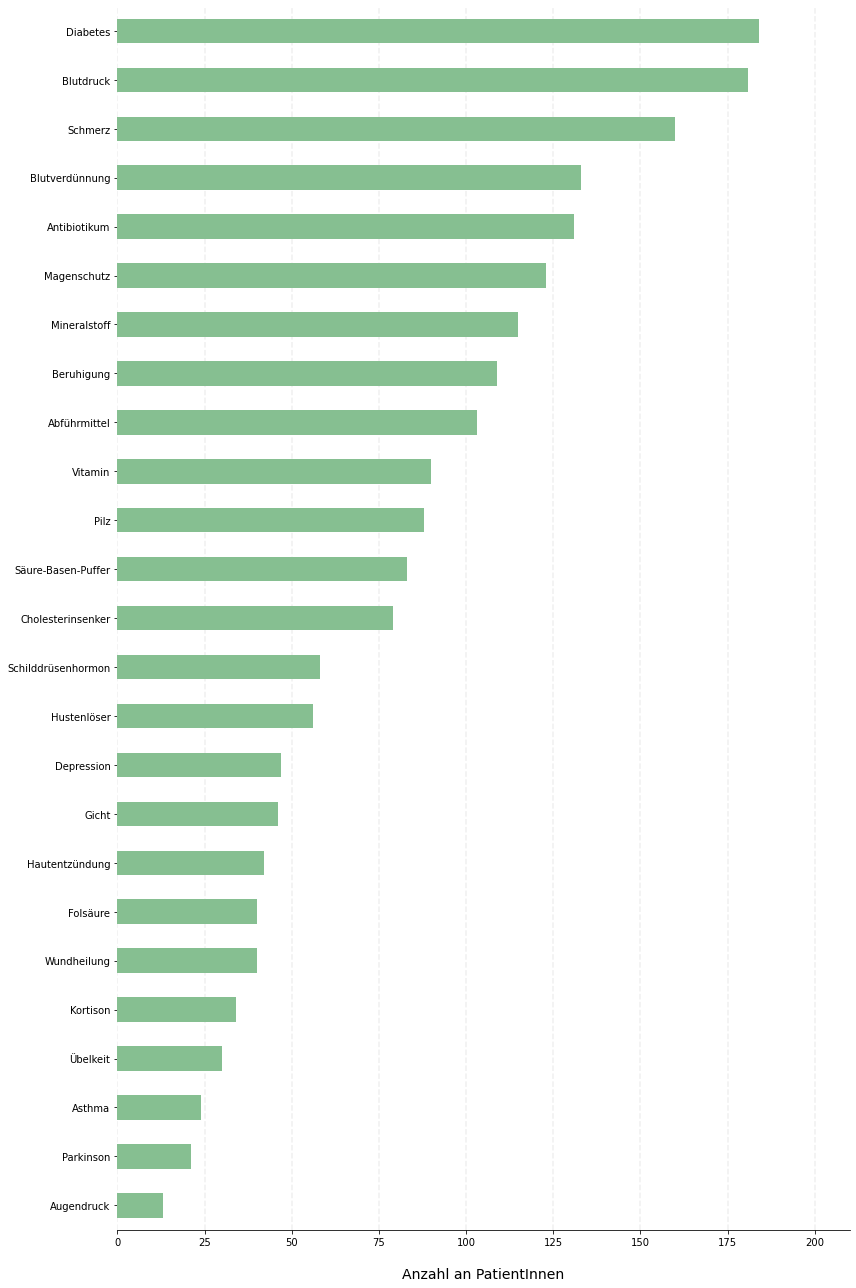

In [9]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)



fig, ax = plt.subplots()
ax = myseries.sort_values().plot(kind='barh',figsize=(12,18),
                            color='#86bf91', zorder=2)
ax.set_ylabel("")
ax.set_xlabel("Anzahl an PatientInnen",labelpad=20, size=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.9, color='#eeeeee', zorder=1)
fig.tight_layout()
fig.savefig("patien_per_medi.pdf")

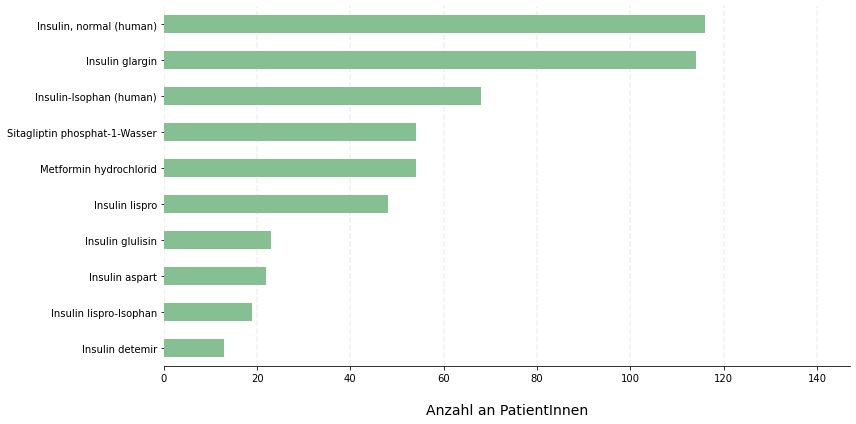

In [10]:

def plot_med(art, name_for_save, figsize=(12,8)):

    df = di.groupby(['inhaltsstoff', 'klientid2']).size().unstack(fill_value=0)
    df2 = df.iloc[:][:] > 0
    myseries = df2.sum(axis=1)
    myseries = myseries[myseries.iloc[:] > 0]
    df3 = pd.DataFrame(myseries, columns=["Patienten"])
    df3["art"] = df3.index.map(mydict)
    df3.art.value_counts()
    df4 = df3.transpose()
    df5 = df4.loc[:,df4.eq(art).any()].transpose()["Patienten"]


    fig, ax = plt.subplots()
    ax = df5.sort_values().plot(kind='barh',figsize=figsize,
                                color='#86bf91', zorder=2)
    ax.set_ylabel("")
    ax.set_xlabel("Anzahl an PatientInnen",labelpad=20, size=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.9, color='#eeeeee', zorder=1)
    fig.tight_layout()
    fig.savefig(name_for_save+".pdf")
plot_med("Diabetes","patien_per_blutzucker_medi",(12,6))

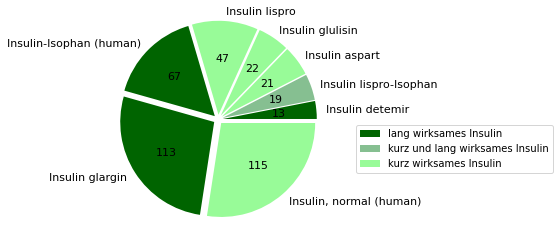

In [11]:
df = di.groupby(['inhaltsstoff', 'klientid2']).size().unstack(fill_value=0)
df2 = df.iloc[:][:] > 0
myseries = df2.loc[df2.index.str.startswith("Insulin")].sum(axis=1).sort_values()
myseries = myseries[myseries.iloc[:] > 2]

a = ["palegreen"]
b = ["darkgreen"]
c = ['#86bf91']

colors = b+c+3*a +b+b+a
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:d}".format(absolute)

myseries.plot(kind="pie", fontsize=11,colors = colors, explode=explode,
              autopct=lambda pct: func(pct, myseries.values))
plt.axis('equal')
plt.ylabel('')
labels = ["lang wirksames Insulin", "kurz und lang wirksames Insulin","kurz wirksames Insulin"]
plt.legend(labels=labels,bbox_to_anchor=(1.3,0.4), loc="center right", fontsize=10,
           bbox_transform=plt.gcf().transFigure)
plt.savefig("pie_insulin.pdf", bbox_inches="tight")

In [12]:
df = di.groupby(['inhaltsstoff', 'klientid2']).size().unstack(fill_value=0)
df2 = df.iloc[:][:] > 0
myseries = df2.loc[df2.index.str.startswith("Insulin")]
myseries_lang = myseries.loc[myseries.index.isin(["Insulin-Isophan (human)","Insulin glargin","Insulin detemir"])]
sum(myseries_lang.sum() > 0) #163
myseries_kurz = myseries.loc[myseries.index.isin(["Insulin, normal (human)","Insulin lispro","Insulin glulisin",
                                                  "Insulin aspart"])]
sum(myseries_kurz.sum() > 0) #171
sum(myseries.sum()>0)

182

In [13]:
mydf_kurz = myseries_kurz.transpose()
mydf_kurz["Insulin kurz"] = mydf_kurz.sum(axis=1) > 0

mydf_lang = myseries_lang.transpose()
mydf_lang["Insulin lang"] = mydf_lang.sum(axis=1) > 0

keine_kurz = list(mydf_kurz[mydf_kurz["Insulin kurz"] == 0].index)
keine_lang = list(mydf_lang[mydf_lang["Insulin lang"] == 0].index)
keine_lang, keine_kurz

([46802,
  102502,
  236702,
  497402,
  593902,
  596502,
  716102,
  743002,
  871101,
  975702,
  1474302,
  1551401,
  2205302,
  2223901,
  2752303,
  2804903,
  2873303,
  3028702,
  4008502,
  4088503,
  4259402,
  5880102],
 [1259202,
  1474302,
  1779703,
  1919202,
  2088002,
  2254302,
  2337003,
  2588403,
  2752303,
  3923002,
  4259402,
  4443302,
  4770902,
  5046202])

In [14]:
df = di.groupby(['inhaltsstoff', 'klientid2']).size().unstack(fill_value=0)
df2 = df.iloc[:][:] > 0
myseries = df2.loc[df2.index.str.startswith("Insulin")].sum(axis=1).sort_values()
myseries = myseries[myseries.iloc[:] > 0]
myseries

df3 = df2.loc[df2.index.isin(["Insulin (human), normal", "Insulin aspart-Isophan", "Insulin degludec"])]
df4 = df3.transpose()
df4[df4.sum(axis=1) > 0]

inhaltsstoff,"Insulin (human), normal",Insulin aspart-Isophan,Insulin degludec
klientid2,,,
46802,False,True,False
931102,False,False,True
2163202,False,True,False
2450403,True,False,False
5489902,False,False,True


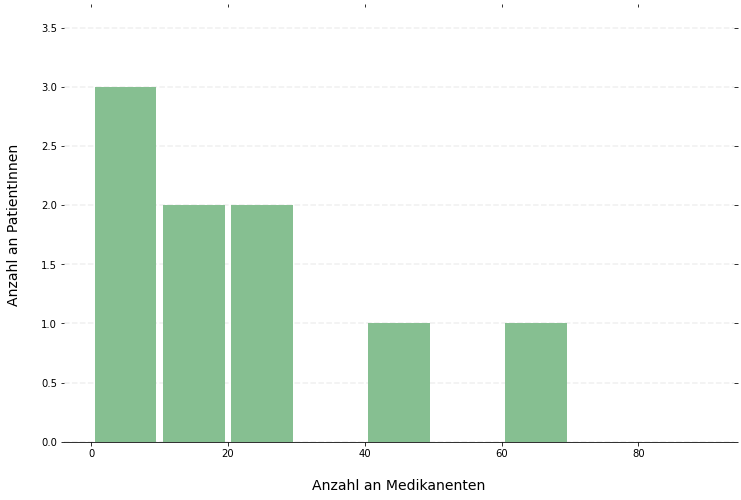

In [15]:





























fig, ax = plt.subplots()


ax = myseries.hist(bins=[0,10, 20, 30, 40, 50, 60, 70, 80,90], grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax.set_xlabel("Anzahl an Medikanenten",labelpad=20, size=14)
ax.set_ylabel("Anzahl an PatientInnen",labelpad=20, size=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="off", left="off", right="off", labelleft="off")
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.9, color='#eeeeee', zorder=1)
fig.savefig("medi_per_patient.pdf")

In [32]:
df = di.groupby(['klientid2', 'inhaltsstoff']).size().unstack(fill_value=0)
df2 = df.iloc[:][:] > 0
#anzahl medikamente pro Klient
myseries = df2.sum(axis=1)
#a = myseries[myseries.iloc[:][:]>60]
a = df.loc[1298201][:]
[wirk for wirk in a.index if a[wirk]>0]

['(2-Octyldodecyl)tetradecanoat',
 'Acacia decurrens/Jojoba/Sonnenblumensamen-Wachs-Polyglyceryl-3-ester',
 'Acetylsalicylsäure',
 'Ambroxol hydrochlorid',
 'Amoxicillin-3-Wasser',
 'Arginin',
 'Arnica montana',
 'Betamethason valerat',
 'Bisabolol',
 'Calciumchlorid-2-Wasser',
 'Carbidopa-1-Wasser',
 'Carnitin',
 'Cefixim-3-Wasser',
 'Ciclopirox',
 'Ciprofloxacin hydrochlorid-1-Wasser',
 'Clavulansäure kalium',
 'Clemastin fumarat',
 'Clotrimazol',
 'Co-trimoxazol',
 'DL-Alanin',
 'DL-alpha-Tocopherol',
 'Dexamethason',
 'Dexpanthenol',
 'Dorzolamid hydrochlorid',
 'Estradiol 0,5-Wasser',
 'Estriol',
 'Fluconazol',
 'Fluocinolon acetonid',
 'Flupredniden 21-acetat',
 'Fosfomycin trometamol',
 'Furosemid',
 'Fusidinsäure-0,5-Wasser',
 'Glutaminsäure',
 'Glycerol',
 'Glycerol behenat',
 'Glycerol dibehenat',
 'Glyceroltridocosanoat',
 'Glycogen',
 'Harnstoff',
 'Histidin hydrochlorid',
 'Hyaluronsäure, Natriumsalz',
 'Hydrocortison',
 'Hydrocortison acetat',
 'Ingwer-Extrakt',
 'Insulin

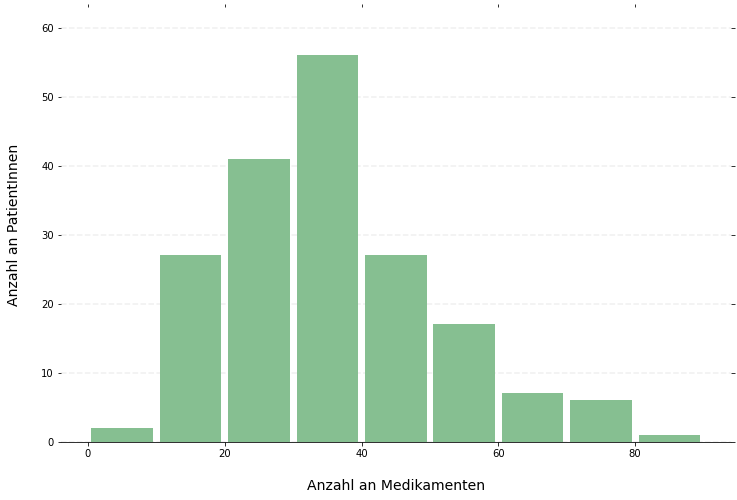

In [17]:
fig, ax = plt.subplots()


ax = myseries.hist(bins=[0,10, 20, 30, 40, 50, 60, 70, 80,90], grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax.set_xlabel("Anzahl an Medikamenten",labelpad=20, size=14)
ax.set_ylabel("Anzahl an PatientInnen",labelpad=20, size=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="off", left="off", right="off", labelleft="off")
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.9, color='#eeeeee', zorder=1)
fig.savefig('medi_per_patient.pdf')

In [58]:
top50=di.inhaltsstoff.value_counts()[:47].index
#len(list(di[di.inhaltsstoff=="Folsäure"].klientid2.unique()))
#for med in top50:
 #   l = len(list(di[di.inhaltsstoff==med].klientid2.unique()))
 #   print(l)
top50.values

array(['Insulin, normal (human)', 'Torasemid',
       'Metamizol natrium-1-Wasser', 'Ramipril', 'Insulin lispro',
       'Insulin glargin', 'Acetylsalicylsäure', 'Insulin-Isophan (human)',
       'Metformin hydrochlorid', 'Pantoprazol natrium-1,5-Wasser',
       'Amlodipin besilat', 'Simvastatin', 'Levothyroxin natrium',
       'Bisoprolol fumarat', 'Insulin aspart', 'Metoprolol succinat',
       'Apixaban', 'Kaliumchlorid', 'Naloxon hydrochlorid-2-Wasser',
       'Levodopa', 'Sitagliptin phosphat-1-Wasser',
       'Natriumhydrogencarbonat', 'Insulin glulisin', 'Furosemid',
       'Natriumchlorid', 'Melperon hydrochlorid', 'Macrogol 3350',
       'Tilidin hydrochlorid-0,5-Wasser', 'Moxonidin', 'Allopurinol',
       'Colecalciferol', 'Insulin lispro-Isophan', 'Pregabalin',
       'Gabapentin', 'Risperidon', 'Lactulose', 'Benserazid hydrochlorid',
       'Insulin detemir', 'Valsartan', 'Dexpanthenol',
       'Salbutamol hemisulfat', 'Mirtazapin', 'Citalopram hydrobromid',
       'Lorazep

In [64]:
klasse = "Diabetes Blutdruck Schmerz Blutdruck Diabetes Diabetes Blutverdünnung Diabetes Diabetes Magenschutz Blutdruck Cholesterinsenker Schilddrüsenhormon Blutdruck Diabetes Blutdruck Blutverdünnung Mineralstoff Schmerz Parkinson Diabetes Säure-Basen-Puffer Diabetes Blutdruck Mineralstoff Beruhigung Abführmittel Schmerz Blutdruck Gicht Vitamin D Diabetes Schmerz Schmerz Beruhigung Abführmittel Parkinson Diabetes Blutdruck Vitamin_B Asthma Depression Depression Beruhigung Blutdruck Blutdruck Augendruck"
klasse = klasse.split()
mydict = dict(zip(list(top50.values), klasse))
di["verwendung"] = di["inhaltsstoff"].map(mydict)
di

,id,klientid,datum,zeitpunkt,medikamentbezeichnung,pzn,anzahl_eingenommen,einheit_eingenommen,atccode,klientid2,inhaltsstoff,menge_pro_medikament,einheit,verwendung
0,155031,4197,2007-11-12,2007-11-12 06:30:00,OMEP 20mg HKM,00300050,1,Stck,None,419701,Omeprazol,20.0,mg,NaN
1,155031,4197,2007-11-12,2007-11-12 06:30:00,OMEP 20mg HKM,00300050,1,Stck,None,419701,Omeprazol,20.0,mg,NaN
2,155031,4197,2007-11-12,2007-11-12 06:30:00,OMEP 20mg HKM,00300050,1,Stck,None,419701,Omeprazol,20.0,mg,NaN
3,155032,4197,2007-11-13,2007-11-13 06:30:00,OMEP 20mg HKM,00300050,1,Stck,None,419701,Omeprazol,20.0,mg,NaN
4,155032,4197,2007-11-13,2007-11-13 06:30:00,OMEP 20mg HKM,00300050,1,Stck,None,419701,Omeprazol,20.0,mg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378774,35823862,34115,2018-04-09,2018-04-09 06:30:00,"Ramipril AAA 2,5mg TAB",02157438,1,Stck,C09AA05,3411503,Ramipril,2.5,mg,Blutdruck
9378775,35823862,34115,2018-04-09,2018-04-09 06:30:00,"Ramipril AAA 2,5mg TAB",02157438,1,Stck,C09AA05,3411503,Ramipril,2.5,mg,Blutdruck
9378776,35823871,34115,2018-04-10,2018-04-10 06:30:00,"Ramipril AAA 2,5mg TAB",02157438,1,Stck,C09AA05,3411503,Ramipril,2.5,mg,Blutdruck
9378777,35823871,34115,2018-04-10,2018-04-10 06:30:00,"Ramipril AAA 2,5mg TAB",02157438,1,Stck,C09AA05,3411503,Ramipril,2.5,mg,Blutdruck


In [ ]:
top10 = list(di.inhaltsstoff.value_counts()[:10].index)
top10_ohneInsulin=[]
for x in top10:
    if x.startswith("Insulin"):
        continue
    else:
        top10_ohneInsulin.append(x)
top10_ohneInsulin

In [8]:
allklients = list(di[di.inhaltsstoff.isin(top10_ohneInsulin)].klientid2.unique())

In [9]:
panto_klients = list(di[di.inhaltsstoff=="Pantoprazol natrium-1,5-Wasser"].klientid2.unique())
metamo_klients = list(di[di.inhaltsstoff=="Metamizol natrium-1-Wasser"].klientid2.unique())
rami_klients = list(di[di.inhaltsstoff=="Ramipril"].klientid2.unique())
acetyl_klients = list(di[di.inhaltsstoff=="Acetylsalicylsäure"].klientid2.unique())
metform_klients = list(di[di.inhaltsstoff=="Metformin hydrochlorid"].klientid2.unique())
tora_klients = list(di[di.inhaltsstoff=="Torasemid"].klientid2.unique())


In [10]:
d = {}
d["panto"] = len(panto_klients)
d["metamo"] = len(metamo_klients)
d["rami"] = len(rami_klients)
d["acetyl"] = len(acetyl_klients)
d["metform"] = len(metform_klients)
d["tora"] = len(tora_klients)
d

{'panto': 123,
 'metamo': 146,
 'rami': 89,
 'acetyl': 99,
 'metform': 54,
 'tora': 132}

In [11]:
b = []
for klient in allklients:
    a=0
    if klient in panto_klients:
        a +=1
    if klient in metamo_klients:
        a+=1
    if klient in rami_klients:
        a+=1
    if klient in acetyl_klients:
        a+=1
    if klient in metform_klients:
        a+=1
    if klient in tora_klients:
        a+=1
    b.append(a)

In [12]:
df =pd.DataFrame(list(zip(allklients, b)), columns=["klientid2","anzahl"])
df.anzahl.value_counts()

4    55
3    49
5    34
2    30
1    10
6     6
Name: anzahl, dtype: int64

In [16]:
mydi = di[di.inhaltsstoff.isin(top50)]

In [19]:
mydi.dtypes

id                                int64
klientid                          int64
datum                    datetime64[ns]
zeitpunkt                datetime64[ns]
medikamentbezeichnung            object
pzn                              object
anzahl_eingenommen                int64
einheit_eingenommen              object
atccode                          object
klientid2                         int64
inhaltsstoff                     object
menge_pro_medikament            float64
einheit                          object
eingenommene_menge              float64
dtype: object

In [18]:
mydi["eingenommene_menge"] = mydi["anzahl_eingenommen"]*mydi["menge_pro_medikament"]

<ipython-input-18-0c1068f00580>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydi["eingenommene_menge"] = mydi["anzahl_eingenommen"]*mydi["menge_pro_medikament"]


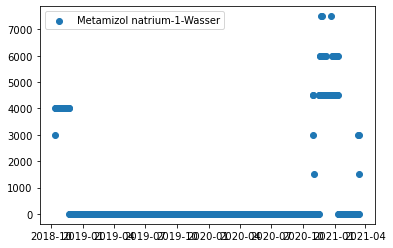

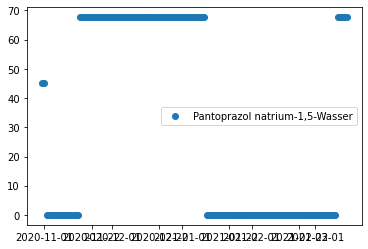

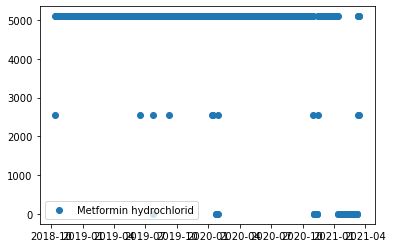

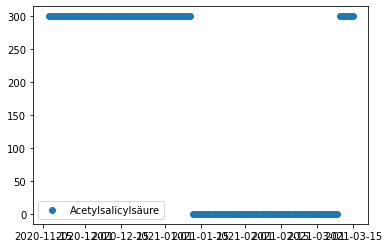

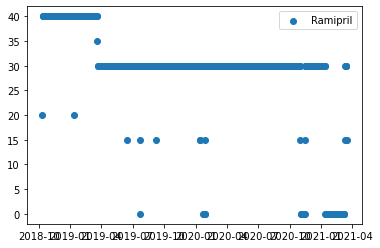

In [16]:
mydi_klient = mydi[mydi.klientid2 == allklients[88]]
medikamente = list(mydi_klient.inhaltsstoff.unique())
for m in medikamente:
    df_temp = mydi_klient[mydi_klient.inhaltsstoff == m]
    df_temp = df_temp[["datum","eingenommene_menge"]]
    df_temp.sort_values(by='datum',inplace=True)
    df_temp.set_index("datum", inplace=True)
    df = df_temp.resample('1d').sum()
    plt.scatter(df.index, df.eingenommene_menge,label=m)
    plt.legend()
    plt.show()